# Importing Libraries
$\texttt{loadmat}$ is used for reading the $\texttt{imageFile.mat}$ file. The functions are implemented from scratch.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

# Markov-1 Process
Generate the covariance for a Markov-1 process with a given parameter $\rho$. The covariance matrix $R$ is given by

$$
R_{i,j} = \rho^{|i-j|}
$$

In [2]:
def R_Markov_1_Process(n, rho):
    x = np.arange(n)
    y = np.arange(n)
    X, Y = np.meshgrid(x, y)
    return rho**(np.abs(X-Y))

# Tridiagonal Matrix
Generate a matrix with a tridiagonal structure for a given value of $\alpha$. For the purpose of illustration, a $4 \times 4$ tridiagonal matrix, $Q_{\alpha}$, is given by

$$Q_{\alpha} = \begin{bmatrix} 1-\alpha & -\alpha & 0 & 0 \\ -\alpha & 1 & -\alpha & 0 \\ 0 & -\alpha & 1 & -\alpha \\ 0 & 0 & -\alpha & 1-\alpha \end{bmatrix}$$

In [3]:
def tridiagonal_mat_Q(n, alpha):
    Q = np.zeros((n, n))
    x = np.arange(n)
    y = np.arange(n)
    X, Y = np.meshgrid(x, y)
    diff = np.abs(X-Y)
    Q[diff == 1] = -alpha
    Q[diff == 0] = 1
    Q[0, 0] = 1-alpha
    Q[-1, -1] = 1-alpha
    return Q

# Haddamard Matrix
Haddamard transform matrices, $H_{n}$, are of the form $N \times N$ where $N = 2^{n}, n \in \{1, 2, ... \}$. All of these matrices can be generated from a core matrix $H_{1}$.

$$H_{1} = \frac{1}{\sqrt{2}}\begin{bmatrix} 1 & 1 \\ 1 & -1 \end{bmatrix}$$

The higher order matrices can be generated from $H_{1}$ recursively as 

$$
H_{n} = H_{n-1}\otimes H_{1} = H_{1} \otimes H_{n-1}, \quad n \geq 2
$$

From now on Walsh-Haddamard transform will be referred to as WHT and Haddamard matrices will be referred to as H matrixes for notational brevity.

In [4]:
def Haddamard_matrix(n):
    H1 = np.array(([1, 1], [1, -1]))/np.sqrt(2)
    H = H1.copy()
    if n == 1:
        return H1
    else:
        for i in range(1, n):
            H = np.kron(H, H1)
        return H

# Inverse of R
If $R$ is the covariance matrix of a Markov-1 process with parameter $\rho$, its inverse, $R^{-1}$ satisfies

$$
\beta^{2}R^{-1} \approx Q_{\alpha}
$$

where,
$Q_{\alpha}$ is the tridiagonal matrix with parameter $\alpha$,

$$
\beta^{2} = \frac{1-\rho^{2}}{1+\rho^{2}}
$$

and, 

$$
\alpha = \frac{\rho}{1+\rho^{2}}
$$

In [5]:
def get_alpha_beta(rho, return_beta_square=True):
    alpha = rho/(1+rho**2)
    beta_sqr = (1-rho**2)/(1+rho**2)
    if return_beta_square:
        return alpha, beta_sqr
    else:
        return alpha, np.sqrt(beta_sqr)

# DCT Matrix
Get the matrix to perform unitary 1D type 2 DCT on an array of length $N$. The unnormalized matrix $C$ has the form

$$
C(k, n) = 2cos\left[\frac{\pi(2n+1)k}{2N}\right], \quad 0 \leq k \leq N-1, \quad 0 \leq n \leq N-1
$$

However, we need to normalize this so that the transform performed it unitary. The normalizing coefficients are

$$
\frac{1}{\sqrt{4N}}, \quad k = 0
$$

$$
\frac{1}{\sqrt{2N}}, \quad k \geq 1
$$

On normalizing we get the desired matrix.

In [6]:
def DCT_mat(N):
    n, k = np.meshgrid(np.arange(N), np.arange(N))
    scale_factor = np.sqrt(2/N)
    C = scale_factor*(np.cos(np.pi*(2*n+1)*k/(2*N)))
    C[k == 0] = np.sqrt(1/N)
    return C

# Energy Packing Efficiency
The energy packing effiency of a covariance matrix $R$ depends on the number of coeffieints we are using and what fraction of the energy can we pack in that. If we are using $m$ coefficients and there are total $N$ coefficients, the energy packing efficiency at $m$, $EPE_{m}$, is given by

$$
EPE_{m} = \frac{\Sigma_{i=1}^{m}R_{i, i}}{\Sigma_{i=1}^{N}R_{i, i}}
$$

Clearly the energy packing efficiency will be high even with low values of $m$ if the first few coefficients contain a bulk of the energy. It is to be noted than an inherent assumption is the coefficients are in the decreasing order, i.e., 

$$
R(1, 1) \geq R(2, 2) \dots \geq R(N, N)
$$

In [7]:
def EPE_vals(R):
    diag_vals = np.abs(np.diag(R))
    total_energy = np.sum(diag_vals)
    energy_packed = np.cumsum(diag_vals)
    return energy_packed/total_energy

# Decorrelation Efficiency
The decorrelation efficiency measures how well the transformed data $R'$ is decorrelated compared to the original data $R$. It is defined as

$$
\eta = 1 - \frac{\alpha}{\beta}
$$

$$
\alpha = \Sigma_{i, j = 1, i \neq j}^{N}|R'_{i, j}|
$$

$$
\beta = \Sigma_{i, j = 1, i \neq j}^{N}|R_{i, j}|
$$

Clearly, for a given $R$, $\eta$ will be high when the off-diagonal elements in $R'$ are close to zero.

In [8]:
def decorrelation_efficiency(R, R_prime):
    n = np.shape(R)[0]
    non_diagonal_vals = 1-np.eye(n)
    R_ = np.abs(non_diagonal_vals*R)
    R_prime_ = np.abs(non_diagonal_vals*R_prime)
    alpha = np.sum(R_prime_)
    beta = np.sum(R_)
    eta = 1-(alpha/beta)
    return eta

# 2D DCT
Perform 2D DCT using 1D DCT matrices. Given an image $U$ of the shape $m \times n$, its 2D DCT $V$ can be calculated as 

$$
V = C_{m}UC_{n}
$$

where $C_{i}$ is the 1D unitary DCT matrix of size $i \times i$

In [9]:
def DCT_2D(image):
    m, n = np.shape(image)
    A = DCT_mat(m)
    B = DCT_mat(n)
    return A@image@(B.T)

# 2D WHT
Perform 2D WHT using 1D WHT matrices. Given an image $U$ of the shape $m \times n$, its 2D WHT $V$ can be calculated as 

$$
V = H_{m}UH_{n}
$$

where $H_{i}$ is the 1D unitary H matrix of size $i \times i$. It must be noted that $(m, n)$ must be powers of $2$ for the transform to be applied.

In [10]:
def WHT_2D(image):
    x, y = np.shape(image)
    n_x = int(np.ceil(np.log2(x)))
    n_y = int(np.ceil(np.log2(y)))
    diff_x = 2**n_x - x
    diff_y = 2**n_y - y
    assert diff_x == 0 and diff_y ==0, "Image dimensions should be a power of 2"
    H_x = Haddamard_matrix(n_x)
    H_y = Haddamard_matrix(n_y)
    transform_coeffs = H_x@image@(H_y.T)
    return transform_coeffs

# Sorted Eigenvectors
$\texttt{NumPy}$'s eigenvalue function does not give the eigenvectors sorted according to decreasing eigenvalue magnitudes. Sort it as it is needed for the calculation of $SVD$.

In [11]:
def sorted_eigenvals(Matrix):
    eigenValues, eigenVectors = np.linalg.eig(Matrix)
    idx = eigenValues.argsort()[::-1]
    idx = eigenValues.argsort()[::-1]
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:, idx]
    return eigenValues, eigenVectors

# Singular Value Decomposition (SVD)
Given a matrix $g$, its $SVD$ is given as

$$
g = A\Sigma B^{T}
$$

$A$ is the matrix with the eigenvalues of $g g^{T}$ as its columns, $B$ is the matrix with the eigenvalues of $g^{T}g$, and $\Sigma$ is the matrix of singular values. Given a matrix $g$ we perform SVD on it using the following steps 
- Perform eigen-decomposition of $gg^{T}$ and $g^{T}g$
- Find the singular value matrix $\Sigma$ using the eigenvalues of $gg^{T}$ and $g^{T}g$
- Return $A, \Sigma, B$ as defined earlier

In [12]:
def SVD(g):
    g = g.astype(np.float64)
    m, n = np.shape(g)
    limiting_dim = min(m, n)
    sigma = np.zeros((m, n))
    S1 = g@(g.T)
    S2 = (g.T)@g
    e1, v1 = sorted_eigenvals(S1)
    e2, v2 = sorted_eigenvals(S2)
    for i in range(limiting_dim):
        sigma[i, i] = (np.sqrt(e1[i])+np.sqrt(e2[i]))/2
        v = v2[:, i]
        # This step is to ensure we have the correct pairing of the eigenvectors in the
        # A and B matrices. This is necessary as v and -v are eigenvectors of the same matrix
        # with the same eigenvalue
        if np.sum((g@v-sigma[i, i]*v1[:, i])**2) > np.sum((g@v+sigma[i, i]*v1[:, i])**2):
            v2[:, i] = -v
    return v1, sigma, v2

# Reconstruct Matrix
Reconstruct a matrix $g$ from its $SVD$ matrices

$$
g = A\Sigma B^{T}
$$

In [13]:
def reconstruct_SVD(A, Sigma, B):
    return A@Sigma@(B.T)

# Reconstruction Error
Remove one singular value at a time from $\Sigma$ and reconstruct the image $\hat{g}_{k}$ where the $k$ highest singular values are removed. Compute the square of  Frobenius norm of the error between $\hat{g}_{k}$ and the original image $g$, i.e., $||g-\hat{g}_{k}||_{F}^{2}$

In [14]:
def reconstruction_errors_SVD(g, A, Sigma, B):
    g = g.astype(np.float64)
    m, n = np.shape(g)
    limiting_dim = min(m, n)
    reconstruction_errors = np.zeros(limiting_dim)
    # start with a copy of the original image
    reconstructed_matrix = g.copy()
    for i in range(limiting_dim):
        # remove the contribution of the ith singular value and its vectors
        reconstructed_matrix -= Sigma[i, i]*np.outer(A[:, i], B[:, i])
        # get the frobenius norm
        reconstruction_errors[i] = np.sum((reconstructed_matrix - g)**2)
    return reconstruction_errors

# Expected Reconstruction Error
On removing the $k$ highest singular values and reconstructing the image, the squared of the Frobenius norm of the error between the original image $g$ and the reconstructed image $\hat{g}_{k}$ is given by

$$
||g-\hat{g}_{k}||_{F}^{2} = \Sigma_{i=1}^{k}\sigma_{i}^{2}
$$

i.e., the sum of the squares of the first $k$ singular values

In [15]:
def theoretical_reconstruction_errors(Sigma):
    # get the non zero entries of the Sigma matrix
    sigma = Sigma[Sigma > 0]
    return np.cumsum(sigma**2)

# Print NumPy Arrays
A function to print $\texttt{NumPy}$ arrays in a pretty manner. Limit the printed arrays to $2$ or $3$ decimals for the sake of readability.

In [16]:
def display_mat(Mat, n_dec=3):
    print(np.round(Mat, decimals=n_dec))

### Reading Images
Reading the data present. It is assumed that the file is present in the same directory as the notebook. Also, define the other parameters from the assignment PDF. Use $3$ decimals as default to print arrays.

In [17]:
g = loadmat('imageFile.mat')['g']
n = 8
rho = 0.91
n_dec_for_display = 3

# Results
The results and inferences are shown

### Computations
Perform all the required computations in this cell. These will be visualized later

In [18]:
# construct the R matrix
R = R_Markov_1_Process(n, rho)
# Get the 2D DCT and WHT of R
R_DCT = DCT_2D(R)
R_WHT = WHT_2D(R)
# compute the energy packing and decorrelation efficiencies
epe_R_DCT = EPE_vals(R_DCT)
epe_R_WHT = EPE_vals(R_WHT)
eta_R_DCT = decorrelation_efficiency(R, R_DCT)
eta_R_WHT = decorrelation_efficiency(R, R_WHT)
# get alpha and beta from rho
alpha, beta_sqr = get_alpha_beta(rho, return_beta_square=True)
# generate the tridiagonal matrix Q
Q = tridiagonal_mat_Q(n, alpha)
# get the scaled inverse of R
beta_sqr_R_inv = beta_sqr*(np.linalg.inv(R))
# Diagonalize Q and scaled inverse of R using DCT
Q_DCT = DCT_2D(Q)
beta_sqr_R_inv_DCT = DCT_2D(beta_sqr_R_inv)
# get SVD matrixes of g
A, Sigma, B = SVD(g)
# reconstruct g using all singular values
g_hat = reconstruct_SVD(A, Sigma, B)
# get the theoretical and experimental reconstruction errors
reconstruction_errors_experimental = reconstruction_errors_SVD(g, A, Sigma, B)
reconstruction_errors_theoretical = theoretical_reconstruction_errors(Sigma)

C:\Users\koushik\AppData\Local\Temp\ipykernel_13892\3682029401.py:11: RuntimeWarning: invalid value encountered in sqrt
  sigma[i, i] = (np.sqrt(e1[i])+np.sqrt(e2[i]))/2


### Energy Packing Efficiency 
Compare the energy packing efficiency of DCT and WHT for $R$, which is the covariance matrix for a Markov-1 process with $\rho=0.91$. Use the energy packing efficiency function as defined earlier. We can clearly see that DCT is doing a better job at packing more energy in the initial few coefficients.

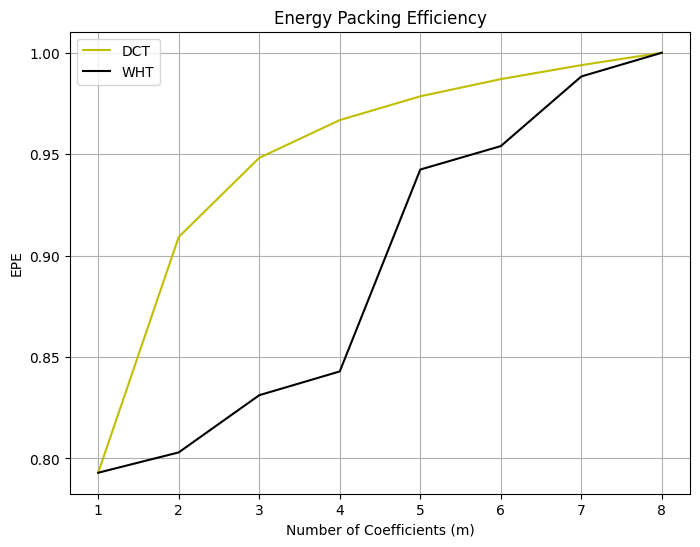

In [19]:
plt.figure(figsize=(8, 6))
plt.plot(np.arange(n)+1, epe_R_DCT, 'y')
plt.plot(np.arange(n)+1, epe_R_WHT, 'black')
plt.xlabel("Number of Coefficients (m)")
plt.ylabel("EPE")
plt.title("Energy Packing Efficiency")
plt.legend(["DCT", "WHT"])
plt.grid(True)
plt.show()

### Decorrelation Efficiency
Compare the decorrelation efficiency of DCT and WHT for $R$, which is the covariance matrix for a Markov-1 process with $\rho=0.91$. Use the decorrelation efficiency function as defined earlier. We can clearly see that DCT is doing a better job at decorrelating $R$.

In [20]:
print(f"Decorrelation Efficiency of R for DCT : {eta_R_DCT}")
print(f"Decorrelation Efficiency of R for WHT : {eta_R_WHT}")

Decorrelation Efficiency of R for DCT : 0.9804711989227338
Decorrelation Efficiency of R for WHT : 0.9485667904674058


### Eigenvectors of R and DCT Basis Vectors
We can see how close the eigenvectors of $R$ are with the DCT basis vectors by trying to diagonalize $R$ with the DCT matrix. If the eigenvectors of $R$ are exactly the same as the DCT basis vectors, we will get a purely diagonal matrix. We can see that the matrix we get is mostly diagonal with very few off-diagonal entries which are not close to zero. It can be concluded that the eigenvectors of $R$ are are close to the DCT basis vectors but not exactly the same.

In [21]:
display_mat(R_DCT, n_dec=2)

[[ 6.34  0.   -0.29  0.   -0.07 -0.   -0.02  0.  ]
 [ 0.    0.93  0.   -0.03  0.   -0.01  0.   -0.  ]
 [-0.29  0.    0.31  0.   -0.    0.   -0.   -0.  ]
 [ 0.   -0.03  0.    0.15  0.   -0.    0.   -0.  ]
 [-0.07 -0.   -0.    0.    0.09  0.   -0.   -0.  ]
 [-0.   -0.01  0.   -0.    0.    0.07  0.   -0.  ]
 [-0.02  0.   -0.    0.   -0.    0.    0.06 -0.  ]
 [ 0.   -0.   -0.   -0.   -0.   -0.   -0.    0.05]]


### Scaled Inverse of R
Calculate $\beta^{2}R^{-1}$ where $R$ is the covariance matrix for a Markov-1 process with $\rho=0.91$. We also display $Q_{\alpha}$, the tridiagonal matrix with parameter $\alpha$ and compare it to $\beta^{2}R^{-1}$. $\alpha$ is calculated from $\rho$ as 

$$
\alpha = \frac{\rho}{1+\rho^{2}}
$$

We can see that the two matrices are almost the same to three places of decimal except for the first and the last diagonal elements. 

In [22]:
display_mat(beta_sqr_R_inv, n_dec_for_display)

[[ 0.547 -0.498 -0.     0.    -0.    -0.     0.    -0.   ]
 [-0.498  1.    -0.498  0.    -0.     0.    -0.     0.   ]
 [-0.    -0.498  1.    -0.498  0.    -0.     0.    -0.   ]
 [-0.    -0.    -0.498  1.    -0.498  0.    -0.     0.   ]
 [-0.    -0.     0.    -0.498  1.    -0.498  0.    -0.   ]
 [-0.     0.    -0.     0.    -0.498  1.    -0.498  0.   ]
 [ 0.    -0.     0.     0.    -0.    -0.498  1.    -0.498]
 [-0.     0.     0.    -0.     0.    -0.    -0.498  0.547]]


In [23]:
display_mat(Q, n_dec_for_display)

[[ 0.502 -0.498  0.     0.     0.     0.     0.     0.   ]
 [-0.498  1.    -0.498  0.     0.     0.     0.     0.   ]
 [ 0.    -0.498  1.    -0.498  0.     0.     0.     0.   ]
 [ 0.     0.    -0.498  1.    -0.498  0.     0.     0.   ]
 [ 0.     0.     0.    -0.498  1.    -0.498  0.     0.   ]
 [ 0.     0.     0.     0.    -0.498  1.    -0.498  0.   ]
 [ 0.     0.     0.     0.     0.    -0.498  1.    -0.498]
 [ 0.     0.     0.     0.     0.     0.    -0.498  0.502]]


### Diagonalizing Ability of DCT
We know that DCT diagonalizes matrices with a tridiagonal structure, $Q_{\alpha}$. We also try to diagonalize $\beta^{2}R^{-1}$ as defined in the previous section using DCT. We can see that for $Q_{\alpha}$, we get an exactly diagonal matrix as expected. For $\beta^{2}R^{-1}$, the matrix is almost diagonal, i.e., most of the off-diagonal elements have small values.

In [24]:
display_mat(beta_sqr_R_inv_DCT, n_dec_for_display)

[[ 0.016  0.     0.015  0.     0.011 -0.     0.006  0.   ]
 [ 0.     0.102 -0.     0.018  0.     0.012  0.     0.004]
 [ 0.015 -0.     0.315  0.     0.015  0.     0.008  0.   ]
 [-0.     0.018  0.     0.634  0.     0.01   0.     0.004]
 [ 0.011 -0.     0.015  0.     1.011  0.     0.006  0.   ]
 [-0.     0.012 -0.     0.01   0.     1.388  0.     0.002]
 [ 0.006  0.     0.008  0.     0.006 -0.     1.707  0.   ]
 [-0.     0.004  0.     0.004 -0.     0.002 -0.     1.921]]


In [25]:
display_mat(Q_DCT, n_dec_for_display)

[[ 0.004  0.    -0.     0.     0.    -0.    -0.     0.   ]
 [-0.     0.08  -0.     0.    -0.    -0.     0.    -0.   ]
 [-0.    -0.     0.296  0.    -0.     0.    -0.     0.   ]
 [-0.     0.     0.     0.619  0.    -0.     0.    -0.   ]
 [ 0.    -0.    -0.     0.     1.     0.    -0.    -0.   ]
 [-0.    -0.     0.    -0.     0.     1.381  0.     0.   ]
 [-0.     0.    -0.     0.    -0.     0.     1.704 -0.   ]
 [-0.    -0.     0.    -0.    -0.     0.    -0.     1.92 ]]


### SVD Reconstruction
Display the given $8 \times 8$ image $g$ and the image obtained on reconstructing $g$ using its $SVD$ matrices. We can see that the values are exactly the same.  

In [26]:
display_mat(g, n_dec_for_display)

[[255 255 255 255 255 255 255 255]
 [255 255 255 100 100 100 255 255]
 [255 255 100 150 150 150 100 255]
 [255 255 100 150 200 150 100 255]
 [255 255 100 150 150 150 100 255]
 [255 255 255 100 100 100 255 255]
 [255 255 255 255  50 255 255 255]
 [ 50  50  50  50 255 255 255 255]]


In [27]:
display_mat(g_hat, n_dec_for_display)

[[nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan]]


### Reconstruction Errors
Remove one singular value at a time from $\Sigma$ and reconstruct the image $\hat{g}_{k}$ where the $k$ highest sigular values are removed. Compute the square of  Frobenius norm of the error between $\hat{g}_{k}$ and the original image $g$, i.e., $||g-\hat{g}_{k}||_{F}^{2}$. On removing the $k$ highest singular values and reconstructing the image, the squared of the Frobenius norm of the error between the original image $g$ and the reconstructed image $\hat{g}_{k}$ is given by

$$
||g-\hat{g}_{k}||_{F}^{2} = \Sigma_{i=1}^{k}\sigma_{i}^{2}
$$

i.e., the sum of the squares of the first $k$ singular values. Both the theoretical and experimental values are plotted. It can be seen that the values are exactly the same.

ValueError: x and y must have same first dimension, but have shapes (8,) and (7,)

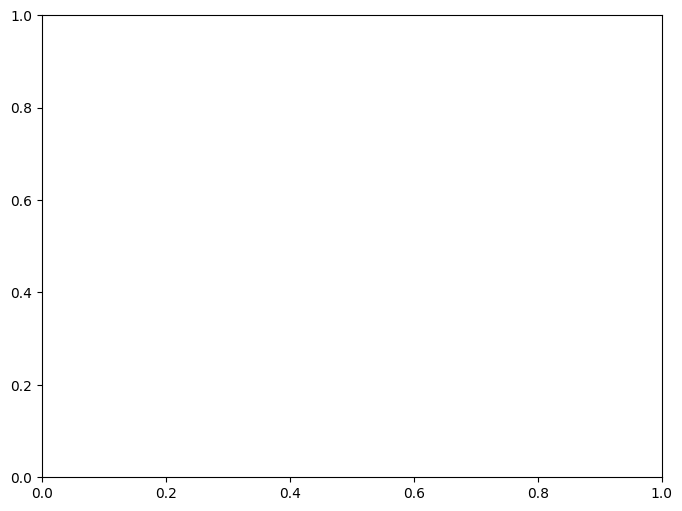

In [28]:
plt.figure(figsize=(8, 6))
plt.plot(np.arange(n)+1, reconstruction_errors_theoretical, 'yellow', linewidth=6)
plt.plot(np.arange(n)+1, reconstruction_errors_experimental,
         '-o', linewidth=2, color="black")
plt.xlabel("singular values removed (k)")
plt.ylabel(r'||g-$\hat{g}_{k}||^{2}$')
plt.legend(["Expected", "Calculated"])
plt.title("Reconstruction Errors")
plt.grid(True)
plt.show()

# Summary
We can summarize with the following observations.
- DCT is better than WHT at both energy packing and decorrelation when we have covariance matrices of Markov-1 processes ($R$)
- Eigenvectors of $R$ are close to the DCT basis vectors but not exactly the same
- $\beta^{2}R^{-1}$ has roughly a tridiagonal structure
- DCT matrix exactly diagonalizes $Q_{\alpha}$, a tridiagonal matrix with parameter $\alpha$ and mostly diagonalizes $\beta^{2}R^{-1}$ but not completely
- Computing the $SVD$ for an image and reconstructing it using all the singular values gives an exact reconstruction
- The theoretical and calculated values for reconstruction errors on removing $k$ singular values is the sum of the squares of those $k$ singular values